In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Olig2/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/Olig2/WT/'
workingDirectory = '/home/h1bennet/brain_aging/results/02_Olig2_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in raw peak files

In [7]:
best_reps = ['00_mouse_BL6_M_10day_Olig2_ChIP_H3K27ac_1_AL_20200610_CTGTAATC_AATTGCTT',
       '00_mouse_BL6_M_10day_Olig2_ChIP_H3K27ac_2_AL_l20200911_AGCTCGCT_GCAGAATC',
       '01_mouse_MPSIIIAhet_M_P21_Olig2_ChIP_H3K27ac_1_AL_20191122_TAGCTT',
       '01_mouse_MPSIIIAhet_M_P21_Olig2_ChIP_H3K27ac_2_AL_20191122_GTAGAG',
       '02_mouse_BL6_F_8week_Olig2_ChIP_H3K27ac_1_JOS_20190814_GGCTAC',
       '02_mouse_BL6_M_8week_Olig2_ChIP_H3K27ac_2_JOS_20191009_GTCCGC',
       '02_mouse_BL6_M_8week_Olig2_ChIP_H3K27ac_3_JOS_20191226_ATGTCA',
       '02_mouse_BL6_M_8week_Olig2_ChIP_H3K27ac_4_JOS_20191226_GTGGCC',
       '02_mouse_BL6_M_9week_Olig2_ChIP_H3K27ac_1_JOS_20190809_CAGATC',
       '03_mouse_MPSIIIAhet_M_4mongh_Olig2_ChIP_H3K27ac_1_AL_l20200925_CTCACCAA_CTAGGCAA',
       '03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_2_AL_l20200925_GTGAATAT_TCTCATTC',
       '03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_3_AL_20201111_GGTCACGA_GTATTATG',
       '05_mouse_BL6_M_23month_Olig2_ChIP_H3K27ac_1_AL_20201121_CGGCGTGA_GCGCCTGT',
       '05_mouse_BL6_M_28month_Olig2_ChIP_H3K27ac_1_AL_20201121_GGTACCTT_AAGACGTC']

In [8]:
df, mat = read_annotated_peaks('./annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
df.index.rename('PeakID', inplace=True)
# OPTIONAL: drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./annotated_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt', sep='\t')

In [9]:
mat.columns.str.split('/').str[-1]

Index(['00_mouse_BL6_M_10day_Olig2_ChIP_H3K27ac_1_AL_20200610_CTGTAATC_AATTGCTT',
       '00_mouse_BL6_M_10day_Olig2_ChIP_H3K27ac_2_AL_l20200911_AGCTCGCT_GCAGAATC',
       '01_mouse_MPSIIIAhet_M_P21_Olig2_ChIP_H3K27ac_1_AL_20191122_TAGCTT',
       '01_mouse_MPSIIIAhet_M_P21_Olig2_ChIP_H3K27ac_2_AL_20191122_GTAGAG',
       '02_mouse_BL6_F_8week_Olig2_ChIP_H3K27ac_1_JOS_20190814_GGCTAC',
       '02_mouse_BL6_M_8week_Olig2_ChIP_H3K27ac_2_JOS_20191009_GTCCGC',
       '02_mouse_BL6_M_8week_Olig2_ChIP_H3K27ac_3_JOS_20191226_ATGTCA',
       '02_mouse_BL6_M_8week_Olig2_ChIP_H3K27ac_4_JOS_20191226_GTGGCC',
       '02_mouse_BL6_M_9week_Olig2_ChIP_H3K27ac_1_JOS_20190809_CAGATC',
       '03_mouse_MPSIIIAhet_M_4mongh_Olig2_ChIP_H3K27ac_1_AL_l20200925_CTCACCAA_CTAGGCAA',
       '03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_2_AL_l20200925_GTGAATAT_TCTCATTC',
       '03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_3_AL_20201111_GGTCACGA_GTATTATG',
       '05_mouse_BL6_M_23month_Olig2_ChIP_H3K27ac_1

# Run differential peak analysis

In [10]:
%%bash
source activate deseq_36
getDiffExpression.pl ./annotated_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt \
00_olig2_10day 00_olig2_10day \
01_olig2_21day 01_olig2_21day \
02_olig2_8week 02_olig2_8week 02_olig2_8week 02_olig2_8week 02_olig2_8week \
03_olig2_4month 03_olig2_4month 03_olig2_4month \
04_olig2_20month 04_olig2_20month \
-peaks  -AvsA> ./diff_vw_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_olig2_10day vs. 01_olig2_21day:
		Total Genes: 47983
		Total Up-regulated in 01_olig2_21day vs. 00_olig2_10day: 4960 (10.337%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_olig2_21day vs. 00_olig2_10day: 4528 (9.437%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2_10day vs. 02_olig2_8week:
		Total Genes: 47983
		Total Up-regulated in 02_olig2_8week vs. 00_olig2_10day: 12079 (25.173%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 02_olig2_8week vs. 00_olig2_10day: 13486 (28.106%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2_10day vs. 03_olig2_4month:
		Total Genes: 47983
		Total Up-regulated in 03_olig2_4month vs. 00_olig2_10day: 10849 (22.610%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 03_olig2_4month vs. 00_olig2_10day: 13050 (27.197%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2

# Create summary plots

## 10day vs. 4 months

In [36]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (49092, 33)
getDiffExpression selected transcripts (47983, 62)
annotatePeaks selected peaks (47983, 33)


In [37]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [40]:
comps = ['00_olig2_10day vs. 01_olig2_21day',
         '00_olig2_10day vs. 02_olig2_8week',
         '00_olig2_10day vs. 03_olig2_4month',
         '00_olig2_10day vs. 04_olig2_20month',
         '01_olig2_21day vs. 02_olig2_8week',
         '01_olig2_21day vs. 03_olig2_4month',
         '01_olig2_21day vs. 04_olig2_20month',
         '02_olig2_8week vs. 03_olig2_4month',
         '02_olig2_8week vs. 04_olig2_20month',
         '03_olig2_4month vs. 04_olig2_20month']

groups = [[[0,1],[2,3]],
          [[0,1],[4,5,6,7,8]],
          [[0,1],[9,10,11]],
          [[0,1],[12,13]],
          [[2,3],[4,5,6,7,8]],
          [[2,3],[9,10,11]],
          [[2,3],[12,13]],
          [[4,5,6,7,8], [9,10,11]],
          [[4,5,6,7,8], [12,13]],
          [[9,10,11], [12,13]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)
    
colors = [['#3182bd', '#de2d26']] * len(groups)

00_olig2_10day vs. 01_olig2_21day
N genes downregulated 4528
N genes upregulated 4960

00_olig2_10day vs. 02_olig2_8week
N genes downregulated 13486
N genes upregulated 12079

00_olig2_10day vs. 03_olig2_4month
N genes downregulated 13050
N genes upregulated 10849

00_olig2_10day vs. 04_olig2_20month
N genes downregulated 11725
N genes upregulated 9818

01_olig2_21day vs. 02_olig2_8week
N genes downregulated 2625
N genes upregulated 2906

01_olig2_21day vs. 03_olig2_4month
N genes downregulated 3615
N genes upregulated 4421

01_olig2_21day vs. 04_olig2_20month
N genes downregulated 4202
N genes upregulated 4776

02_olig2_8week vs. 03_olig2_4month
N genes downregulated 358
N genes upregulated 232

02_olig2_8week vs. 04_olig2_20month
N genes downregulated 1048
N genes upregulated 224

03_olig2_4month vs. 04_olig2_20month
N genes downregulated 2
N genes upregulated 9



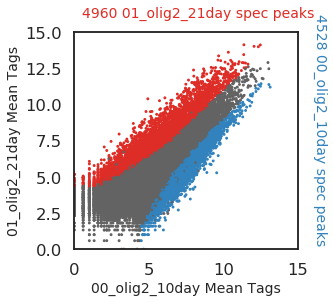

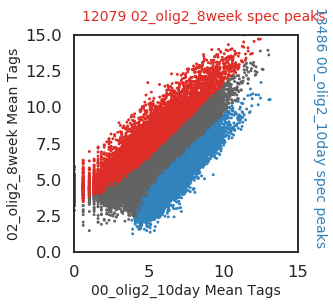

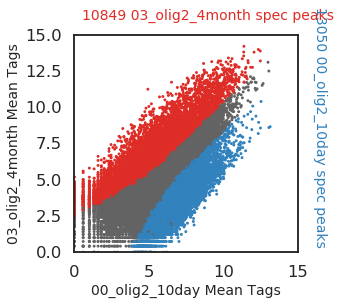

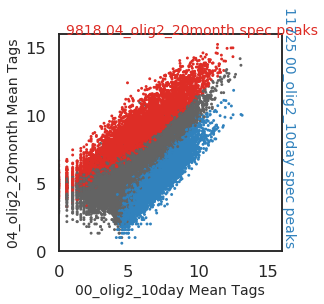

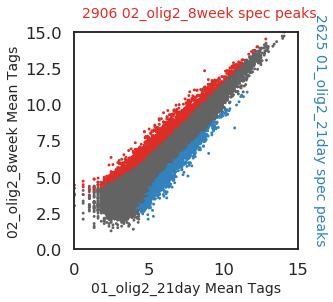

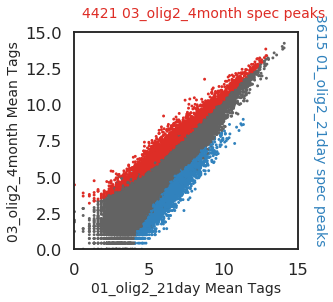

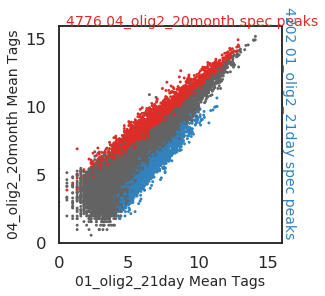

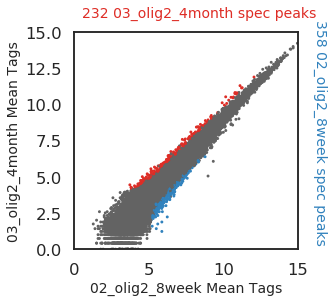

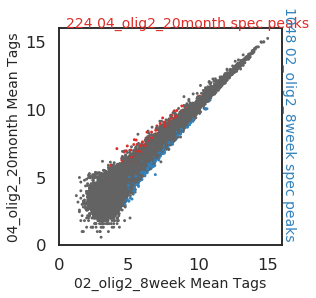

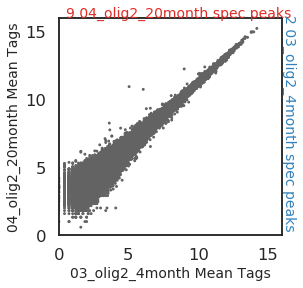

In [41]:
fc = np.log2(2)
pval = 0.05
textax = 16

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,textax,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(textax,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

In [15]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (33165, 23)
getDiffExpression selected transcripts (32446, 26)
annotatePeaks selected peaks (32446, 23)


In [16]:
comp_dict.keys()

dict_keys(['00_sox9_10day vs. 01_sox9_4month'])

# Extract peaks for an analysis in GREAT

In [43]:
comps = ['00_olig2_10day vs. 01_olig2_21day',
         '00_olig2_10day vs. 02_olig2_8week',
         '00_olig2_10day vs. 03_olig2_4month',
         '00_olig2_10day vs. 04_olig2_20month',
         '01_olig2_21day vs. 02_olig2_8week',
         '01_olig2_21day vs. 03_olig2_4month',
         '01_olig2_21day vs. 04_olig2_20month',
         '02_olig2_8week vs. 03_olig2_4month',
         '02_olig2_8week vs. 04_olig2_20month',
         '03_olig2_4month vs. 04_olig2_20month']

In [44]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_olig2_10day',
         '01_olig2_21day',
         '02_olig2_8week',
         '03_olig2_4month',
         '04_olig2_20month']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_olig2_10day ...

0
For comp: 00_olig2_10day vs. 01_olig2_21day
Union set at: 4528 peaks
Intersection set at: 4528 peaks

1
For comp: 00_olig2_10day vs. 02_olig2_8week
Union set at: 13708 peaks
Intersection set at: 4306 peaks

2
For comp: 00_olig2_10day vs. 03_olig2_4month
Union set at: 15074 peaks
Intersection set at: 4222 peaks

3
For comp: 00_olig2_10day vs. 04_olig2_20month
Union set at: 15347 peaks
Intersection set at: 4099 peaks

4
For comp: 01_olig2_21day vs. 02_olig2_8week
Union set at: 15347 peaks
Intersection set at: 4099 peaks

4
For comp: 01_olig2_21day vs. 03_olig2_4month
Union set at: 15347 peaks
Intersection set at: 4099 peaks

4
For comp: 01_olig2_21day vs. 04_olig2_20month
Union set at: 15347 peaks
Intersection set at: 4099 peaks

4
For comp: 02_olig2_8week vs. 03_olig2_4month
Union set at: 15347 peaks
Intersection set at: 4099 peaks

4
For comp: 02_olig2_8week vs. 04_olig2_20month
Union set at: 15347 peaks
Intersection set at: 4099 peaks

4
For comp: 03_ol

In [18]:
peak_lists.keys()

dict_keys(['00_sox9_10day_union', '00_sox9_10day_intersection', '01_sox9_4month_union', '01_sox9_4month_intersection'])

### Save peak and bed files for GREAT analysis

In [19]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [20]:
for key in peak_lists.keys():
    # save cell specific promoters
    diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4].to_csv(
        './great_analysis/peak_files/'+key+'_act_peaks.txt',
        sep='\t')

Save full set of peaks for background

In [21]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/sox9_all_peaks.txt',
    sep='\t')

Convert to bed files

In [22]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

rm: cannot remove ‘./peak_to_bed_great.sh’: No such file or directory


In [23]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [24]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [25]:
!cp ./great_analysis/bed_files/*union* ./bed_files/

In [26]:
!ls ./bed_files/

00_sox9_10day_union_act_peaks.bed   fw_peaks_merged.bed   vw_peaks_merged.bed
01_sox9_4month_union_act_peaks.bed  nfr_peaks_merged.bed


Give track names for uploading to genome browser

In [27]:
%%bash

echo 'track name="Sox9_H3K27Ac_10day_peaks" description="Sox9 Nuclei 10day H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/00_sox9_10day_union_act_peaks.bed \
> temp && mv temp ./bed_files/00_sox9_10day_union_act_peaks.bed

echo 'track name="Sox9_H3K27Ac_4month_peaks" description="Sox9 Nuclei 4month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/01_sox9_4month_union_act_peaks.bed \
> temp && mv temp ./bed_files/01_sox9_4month_union_act_peaks.bed

Next step... check these peaks on browser to make sure they look specific

In [28]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [30]:
diff_peak.sort_values('00_sox9_10day vs. 01_sox9_4month adj. p-value', ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,Gene Type,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA,00_sox9_10day vs. 01_sox9_4month Log2 Fold Change,00_sox9_10day vs. 01_sox9_4month p-value,00_sox9_10day vs. 01_sox9_4month adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr3-130626604-5,chr3,130616497,130639191,+,656.940002,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_027907, intron 6 of 12)","intron (NM_027907, intron 6 of 12)",10269.0,NM_027907,...,protein-coding,6.920029,6.682478,10.449449,10.381628,10.684041,4.101488,1.165124e-100,3.780363e-96,chr3:130616497-130639191
Merged-chr5-146415688-10,chr5,146397894,146432985,+,523.359985,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_145155, intron 1 of 9)","intron (NM_145155, intron 1 of 9)",30433.0,NM_145155,...,protein-coding,8.710918,8.494155,11.111513,11.206498,11.209952,2.745163,8.072505e-84,1.309602e-79,chr5:146397894-146432985
Merged-chr9-48739804-6,chr9,48726872,48751935,+,537.799988,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_001033324, intron 3 of 6)","intron (NM_001033324, intron 3 of 6)",96542.0,NM_001033324,...,protein-coding,7.277151,7.553994,10.365278,10.565199,10.601886,3.358641,8.714269e-82,9.424772e-78,chr9:48726872-48751935
Merged-chr18-11900853-8,chr18,11880798,11923837,+,846.662476,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_022021, intron 3 of 8)",MER126|DNA|DNA,-61879.0,NR_035447,...,ncRNA,8.967854,9.163097,11.376814,11.462505,11.613000,2.561530,1.237799e-72,1.004041e-68,chr18:11880798-11923837
Merged-chr6-31210997-8,chr6,31197500,31222989,+,446.787506,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NR_110469, intron 1 of 3)","intron (NR_110469, intron 1 of 3)",8230.0,NR_110471,...,ncRNA,7.676813,7.886064,10.432552,10.687864,10.726477,3.062091,2.163126e-72,1.403696e-68,chr6:31197500-31222989
Merged-chr2-134970301-3,chr2,134959485,134982057,+,982.166626,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_001145830, intron 2 of 31)","intron (NM_001145830, intron 2 of 31)",184607.0,NM_001145830,...,protein-coding,7.678684,7.339797,10.376654,10.261833,10.456398,3.116147,3.127490e-72,1.691243e-68,chr2:134959485-134982057
Merged-chr19-38268307-8,chr19,38258188,38283034,+,610.187500,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_020278, intron 2 of 7)",(CCCA)n|Simple_repeat|Simple_repeat,5829.0,NM_020278,...,protein-coding,8.615098,8.692038,10.921348,10.951544,11.134576,2.509304,1.383381e-66,6.412166e-63,chr19:38258188-38283034
Merged-chr7-144940560-2,chr7,144937514,144943615,+,664.699951,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,promoter-TSS (NM_007631),promoter-TSS (NM_007631),-639.0,NM_007631,...,protein-coding,9.299956,9.540293,6.000321,6.386771,5.827140,-3.806620,1.411433e-63,5.724421e-60,chr7:144937514-144943615
Merged-chr7-17059035-5,chr7,17053347,17063625,+,1009.919983,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_001162950, intron 1 of 14)","intron (NM_001162950, intron 1 of 14)",-1807.0,NM_016868,...,protein-coding,8.044079,8.467563,10.765504,11.092962,11.147359,2.926467,7.844242e-61,2.827937e-57,chr7:17053347-17063625


In some cases here the merged NFR peak does seem to cause some issues - i think because there are so many samples that you can end with a large amout of overlap so you just get one mega peak when you merge. This wasn't a problem when we did only two groups as a comparison - so maybe our analyses need to be pairwise. Could also be an issue because we have 5 replicates for the 8 week samples and they alone could lead to merged NFR regions.

Although I guess we are just calling differential peaks based on variable width regions, so the answer could be to just make group specific merged NFR peaks and pull those! 

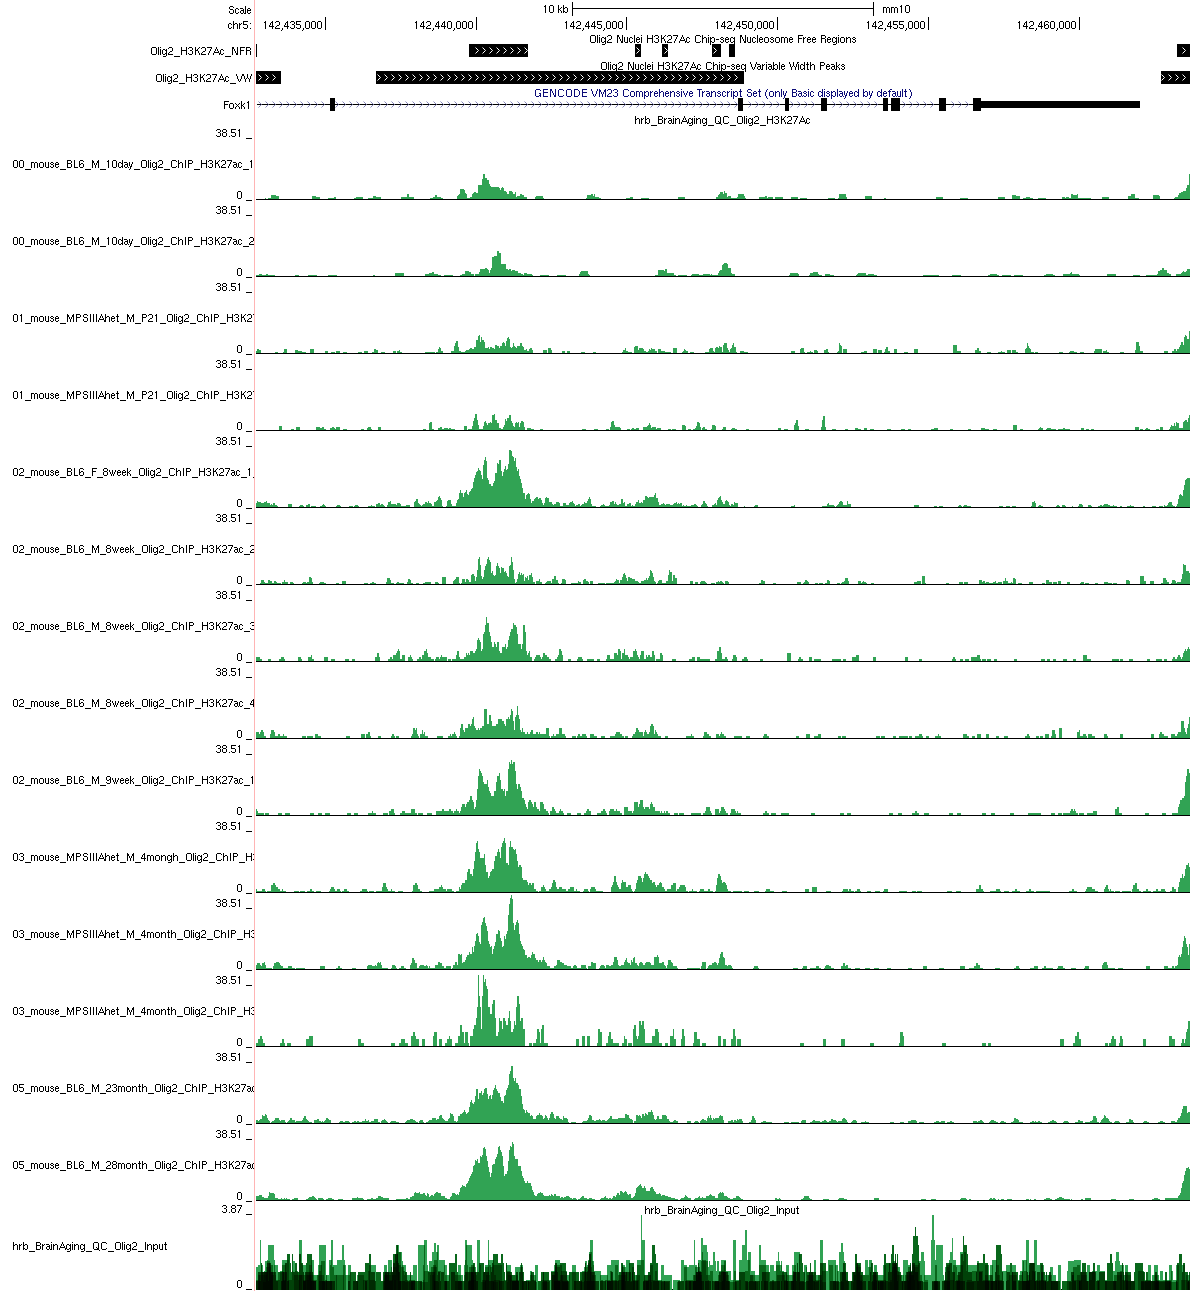